In [43]:
# !pip install feather-format

In [44]:
import csv
import xml.etree.cElementTree as et
import pandas as pd
import numpy as np
from bokeh.plotting import figure, output_file, show
from bokeh.embed import components
import os
import feather
import pickle
from bokeh.io import show
from bokeh.models import LogColorMapper
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') #for presentation purposes only

## Counties webscraping dataset

In [45]:
#code to read in the counties data
def _read_data():
    '''
    '''
    nan = float('NaN')
    data = {}
    with open('data/US_Counties.csv', encoding='utf-8') as f:
        next(f)
        reader = csv.reader(f, delimiter=str(','), quotechar=str('"'))
        for row in reader:
            name, dummy, state, dummy, geometry, dummy, dummy, dummy, det_name, state_id, county_id, dummy, dummy = row
            xml = et.fromstring(geometry)
            lats = []
            lons = []
            for i, poly in enumerate(xml.findall('.//outerBoundaryIs/LinearRing/coordinates')):
                if i > 0:
                    lats.append(nan)
                    lons.append(nan)
                coords = (c.split(',')[:2] for c in poly.text.split())
                lat, lon = list(zip(*[(float(lat), float(lon)) for lon, lat in
                    coords]))
                lats.extend(lat)
                lons.extend(lon)
            data[(int(state_id), int(county_id))] = {
                'name' : name,
                'detailed name' : det_name,
                'state' : state,
                'lats' : lats,
                'lons' : lons,
            }
    return data

In [7]:
os.chdir('marketfriendliness')

/Users/hayes/Dropbox/Work/DI/Capstone/marketfriendliness


In [46]:
counties = _read_data()
counties = {
    code: county for code, county in counties.items()} 

county_xs = [county["lons"] for county in counties.values()]
county_ys = [county["lats"] for county in counties.values()]

county_names = [county['name'] for county in counties.values()]

county_states = [county['state'] for county in counties.values()]

In [9]:
data=dict(
    x=county_xs,
    y=county_ys,
    name=county_names,
    state=county_states
)

In [10]:
state_list = list(set(data['state']))
state_list = [x.upper() for x in state_list]
state_list.sort()
state_list
#need to remove AS, GU, MP, PR, DC, VI
bad_state_list = ['AS','DC','GU','MP','PR','VI']
for item in bad_state_list:
    state_list.remove(item)
len(state_list)

50

## Cleaning Freddie Mac DF

In [12]:
#cleaning each data file
for year_val in range(1999, 2017):
    filename = 'data/mortgage/sample_orig_' + str(year_val) + '.txt'
    dmort = pd.read_csv(filename, sep='|', delimiter=None, names=['fico','dt_first_pi','flag_fthb','loan_end_date','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fifteen','sixteen','st','eighteen','zipcode','twenty','twentone','twentytwo','twentythree','twentyfour','twentyfive','twentysix','twentyseven'])
    dmort = dmort[['fico','dt_first_pi','flag_fthb','zipcode','st']]
    #FTHB recode
    dmort['flag_fthb'] = dmort['flag_fthb'].replace("9",0)
    dmort['flag_fthb'] = dmort['flag_fthb'].replace("Y", 1)
    dmort['flag_fthb'] = dmort['flag_fthb'].replace("N",0)
    dmort['flag_fthb'].astype(int)
    #Fix zipcodes to be a number-- it has some weird values throwing it off
    dmort['zipcode'] = dmort['zipcode'].fillna(0).astype(int)
    dmort['zipcode'] = dmort['zipcode'].astype(str)
    dmort = dmort[dmort['zipcode'] != '0']
    dmort['zipcode'] = [x.rjust(5, '0') for x in dmort['zipcode']]
    dmort['zipcode'] = [str(x)[:-2] for x in dmort.zipcode]
    #Creating datetime
    dmort['loanDate'] = pd.to_datetime(dmort['dt_first_pi'], format= '%Y%m')
    #Cleaning state
    dmort = dmort[dmort['st'] != 'PR']
    dmort = dmort[dmort['st'] != 'DC']
    dmort = dmort[dmort['st'] != 'VI']
    dmort = dmort[dmort['st'] != 'GU']
    dmort = dmort[dmort['st'] != 'MP']
    dmort = dmort[dmort['st'] != 'AS']
    #Cleaning fico
    dmort = dmort[dmort['fico'] != 9999]
    dmort = dmort[dmort['fico'] > 300]
    dmort = dmort.drop(columns='dt_first_pi')
    savefile = 'data/mortgage/dm' + str(year_val) + '.csv'
    dmort.to_csv(savefile, index=False)


/Users/hayes/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
#combining all the data files
df = pd.read_csv('data/mortgage/dm1999.csv')
for year_val in range(2000, 2017):
    add_file = 'data/mortgage/dm' + str(year_val) + '.csv'
    df2 = pd.read_csv(add_file)
    df = df.append(df2, ignore_index=True)
    print(df.shape)
df.to_csv('data/mortgage/mort_all_years.csv')

(98508, 5)
(147967, 5)
(197604, 5)
(247378, 5)
(297120, 5)
(346743, 5)
(396430, 5)
(446076, 5)
(495778, 5)
(545583, 5)
(595404, 5)
(645236, 5)
(695065, 5)
(744871, 5)
(794690, 5)
(844526, 5)
(894358, 5)


In [15]:
df.head(5)

,fico,flag_fthb,zipcode,st,loanDate
0,799,0,261,WV,1999-03-01
1,635,0,447,OH,2002-12-01
2,787,0,305,GA,1999-05-01
3,726,0,660,KS,1999-04-01
4,748,0,452,OH,1999-05-01


In [48]:
df = pd.read_csv('data/mortgage/mort_all_years.csv')

In [49]:
state_list = df['st'].unique()
state_list

array(['WV', 'OH', 'GA', 'KS', 'CA', 'UT', 'MD', 'MI', 'PA', 'FL', 'AZ',
       'NY', 'MA', 'NJ', 'MN', 'WI', 'CT', 'WA', 'SC', 'TX', 'MT', 'CO',
       'TN', 'IA', 'NM', 'IN', 'ME', 'VA', 'MO', 'NC', 'OR', 'NV', 'IL',
       'AK', 'KY', 'MS', 'ND', 'NE', 'LA', 'NH', 'AL', 'RI', 'ID', 'OK',
       'SD', 'AR', 'HI', 'VT', 'WY', 'DE'], dtype=object)

In [50]:
#getting average values
df_FM = df.groupby(['zipcode'])['fico', 'flag_fthb'].mean()
df_FM['zipcode'] = df_FM.index
df_FM['zipcode'] = [str(x).rjust(3, '0') for x in df_FM['zipcode']]
df_FM['fico'] = [int(x) for x in df_FM['fico']]
df_FM['flag_fthb']= [round(x*100, 2) for x in df_FM['flag_fthb']]
df_FM.head(5)

,fico,flag_fthb,zipcode
zipcode,,,
10,740,11.94,010
11,724,14.29,011
12,749,6.90,012
13,740,13.57,013
14,733,12.25,014


## ARIMA Model

Autoregressive integrated moving average

In [51]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [52]:
#getting average values
df_pred = df.groupby(['zipcode', 'loanDate'])['fico', 'flag_fthb'].mean()
df_pred.head(5)
# df_pred = df_pred.drop(columns = 'zipcode')
# df_pred['zipcode'] = df_pred.index
df_pred = df_pred.reset_index()
df_pred['zipcode'] = [str(x).rjust(3, '0') for x in df_pred['zipcode']]
df_pred['loanDate'] = pd.to_datetime(df_pred['loanDate'], format= '%Y-%m-%d')
# df_pred1 = df_pred1.reset_index(level='zipcode')
df_pred['fico'] = [int(x) for x in df_pred['fico']]
print(df_pred.shape)
print(df_pred.tail(5))
zipcode_list = df_pred.zipcode.unique()

(147137, 4)
       zipcode   loanDate  fico  flag_fthb
147132     999 2015-05-01   766        0.0
147133     999 2016-05-01   753        0.0
147134     999 2016-06-01   806        0.0
147135     999 2016-08-01   793        0.0
147136     999 2016-11-01   777        0.0


In [21]:
df_pred.head(5)

,zipcode,loanDate,fico,flag_fthb
0,010,1999-03-01,697,0.166667
1,010,1999-04-01,707,0.142857
2,010,1999-05-01,721,0.000000
3,010,1999-06-01,703,0.000000
4,010,1999-07-01,728,0.000000


In [53]:
zipcode_fico_preds = dict()
zipcode_fthb_preds = dict()
zipsorted_df = df_pred.sort_values(by=['zipcode'])
zipcount = 0

for zippie in zipcode_list:
    df_test_pred = zipsorted_df[zipsorted_df['zipcode'] == str(zippie)]
    df_test_pred = df_test_pred.drop(columns = ['zipcode', 'flag_fthb'])
    df_test_pred = df_test_pred.set_index('loanDate')
    #now I have the fico df ready to go 
    # fit model
    try:
        model = ARIMA(df_test_pred, order=(2,0,2))
        model_fit = model.fit(disp=0)
        #make prediction
        prediction = model_fit.forecast(steps=6)[0].mean()
        #store fico prediction
        zipcode_fico_preds[zippie] = prediction
    except:
        pass
    zipcount += 1
    if zipcount % 50 == 0:
        print('%s zips down' % str(zippie))
    
#         ##repeat process for fthb
#     df_test_pred2 = zipsorted_df[zipsorted_df['zipcode'] == str(zippie)]
#     df_test_pred2 = df_test_pred2.drop(columns = ['zipcode', 'fico'])
#     df_test_pred2 = df_test_pred2.set_index('loanDate')
#     print(df_test_pred2.head(5))
#     #now I have the fico df ready to go 
#     # fit model
#     model2 = ARIMA(df_test_pred2, order=(2,1,2))
#     model_fit2 = model2.fit(disp=0)
#     #make prediction
#     prediction = model_fit2.forecast(steps=6)[0].mean()
#     #store fico prediction
#     zipcode_fthb_preds[zippie] = prediction

060 zips down
120 zips down
170 zips down
227 zips down
278 zips down
329 zips down
386 zips down
440 zips down
491 zips down
548 zips down
605 zips down
661 zips down
722 zips down
778 zips down
832 zips down
904 zips down
958 zips down


In [54]:
zip_fico_preds = []
for key, value in zipcode_fico_preds.items():
    temp = [key,value]
    zip_fico_preds.append(temp)
zip_fico_preds[:5]

[['010', 714.6909286461961],
 ['013', 737.7729069419771],
 ['016', 715.7345756266654],
 ['017', 742.6122953591871],
 ['018', 707.5623542449035]]

In [55]:
zipcount = 0

for zippie in zipcode_list:
    df_test_pred = zipsorted_df[zipsorted_df['zipcode'] == str(zippie)]
    df_test_pred = df_test_pred.drop(columns = ['zipcode', 'fico'])
    df_test_pred = df_test_pred.set_index('loanDate')
    #now I have the fico df ready to go 
    # fit model
    try:
        model = ARIMA(df_test_pred, order=(2,0,2))
        model_fit = model.fit(disp=0)
        #make prediction
        prediction = model_fit.forecast(steps=6)[0].mean()
        #store fico prediction
        zipcode_fthb_preds[zippie] = prediction
    except:
        pass
    zipcount += 1
    if zipcount % 50 == 0:
        print('%s zips down' % str(zippie))

060 zips down
120 zips down
170 zips down
227 zips down
278 zips down
329 zips down
386 zips down
440 zips down
491 zips down
548 zips down
605 zips down
661 zips down
722 zips down
778 zips down
832 zips down
904 zips down
958 zips down


In [56]:
zip_fthb_preds = []
for key, value in zipcode_fthb_preds.items():
    temp = [key,value]
    zip_fthb_preds.append(temp)
zip_fthb_preds[:5]

[['010', 0.13882097278147842],
 ['015', 0.11420874525215978],
 ['016', 0.15968778378549633],
 ['017', 0.10968497847566265],
 ['018', 0.08509418228086123]]

In [5]:
df_test_pred = df_pred[df_pred['zipcode'] == '945']
# print(df_test_pred.head(5))
df_test_pred = df_test_pred.drop(columns = ['zipcode', 'flag_fthb'])
df_test_pred = df_test_pred.set_index('loanDate')
df_test_pred.tail(5)

,fico
loanDate,
2016-11-01,749
2016-12-01,753
2017-01-01,749
2017-02-01,756
2017-03-01,716


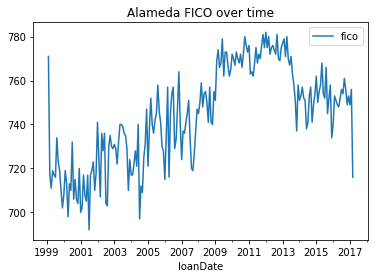

In [6]:
df_test_pred.plot()
pyplot.title('Alameda FICO over time')
# pyplot.savefig('visualizations/fico_over_time_alameda.png')
pyplot.show()

/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


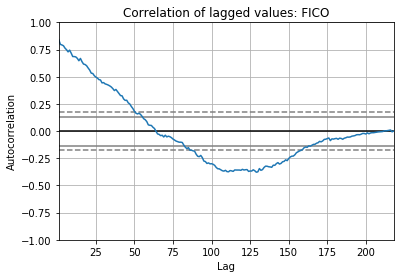

In [7]:
autocorrelation_plot(df_test_pred)
pyplot.title('Correlation of lagged values: FICO')
# pyplot.savefig('visualizations/timecorrelation_over_time_alameda.png')
pyplot.show()

/opt/conda/envs/data3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/data3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.fico   No. Observations:                  217
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -833.934
Method:                       css-mle   S.D. of innovations             11.283
Date:                Wed, 14 Nov 2018   AIC                           1675.868
Time:                        20:46:31   BIC                           1689.388
Sample:                    03-01-1999   HQIC                          1681.330
                         - 03-01-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0666      0.435     -0.153      0.879      -0.919       0.786
ar.L1.D.fico    -0.4627      0.071     -6.559      0.000      -0.601      -0.324
ar.L2.D.fico    -0.3045      0.070     -4.33

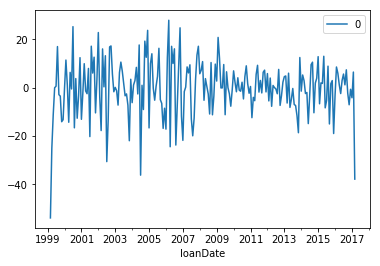

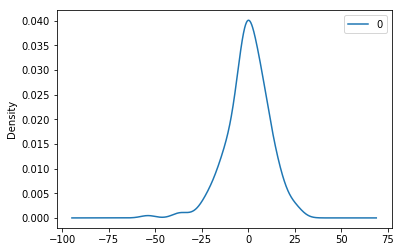

                0
count  217.000000
mean    -0.172174
std     11.442325
min    -53.933443
25%     -5.470434
50%      0.132196
75%      6.600988
max     27.950662


In [11]:
# fit model
model = ARIMA(df_test_pred, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.savefig('visualizations/residuals_alameda.png')
pyplot.show()
residuals.plot(kind='kde')
pyplot.savefig('visualizations/residuals_kdensity_alameda.png')
pyplot.show()
print(residuals.describe())

In [ ]:
from sklearn.metrics import mean_squared_error
import warnings
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [1, 2, 5,]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_test_pred.values, p_values, d_values, q_values)


ARIMA(1, 0, 0) MSE=88.894
ARIMA(1, 0, 1) MSE=69.154
ARIMA(1, 0, 2) MSE=70.282
ARIMA(1, 1, 0) MSE=76.352
ARIMA(1, 1, 1) MSE=75.580
ARIMA(1, 1, 2) MSE=75.413
ARIMA(2, 0, 0) MSE=76.371
ARIMA(2, 1, 0) MSE=70.506


In [8]:
X = df_test_pred.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


predicted=775.877583, expected=776.000000
predicted=775.917744, expected=763.000000
predicted=768.137943, expected=764.000000
predicted=767.662152, expected=762.000000
predicted=762.773888, expected=768.000000
predicted=766.163824, expected=775.000000
predicted=770.435769, expected=768.000000
predicted=769.278380, expected=772.000000
predicted=772.588817, expected=770.000000
predicted=769.970905, expected=776.000000
predicted=774.245738, expected=781.000000
predicted=777.385426, expected=775.000000
predicted=776.506502, expected=782.000000
predicted=781.044246, expected=775.000000
predicted=776.383053, expected=780.000000
predicted=780.184658, expected=772.000000
predicted=774.410286, expected=775.000000
predicted=776.296670, expected=776.000000
predicted=774.988983, expected=774.000000
predicted=774.899385, expected=772.000000
predicted=773.752654, expected=781.000000
predicted=777.895946, expected=770.000000
predicted=772.589370, expected=769.000000
predicted=772.925399, expected=775

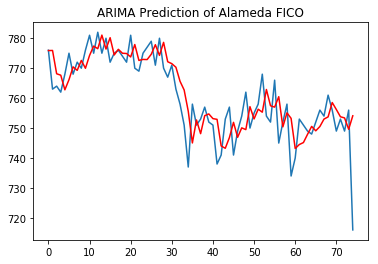

In [10]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.title('ARIMA Prediction of Alameda FICO')

pyplot.savefig('visualizations/arimapreds_over_time_alameda.png')
pyplot.show()

In [11]:
df_test_time = df_pred
# df_test_time = df_test_pred.index.to_julian_date()
df_test_time['Date'] = df_pred['loanDate'].map(pd.datetime.toordinal)
df_test_time = df_test_time[df_test_time['zipcode'] == '945']
df_test_time = df_test_time.drop(columns=['loanDate', 'zipcode','flag_fthb'])
df_test_time.sort_values(by=['Date'])
df_test_time.head(5)

,fico,Date
137861,771,729786
137862,717,729814
137863,711,729845
137864,719,729875
137865,717,729906


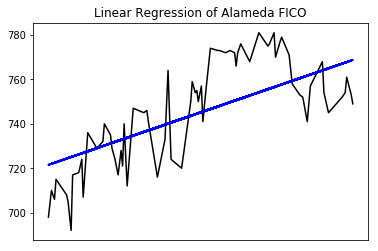

In [387]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df_test_time['Date'], df_test_time['fico'], test_size=0.33)


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(np.array(X_train).reshape(-1, 1), y_train)

# Make predictions using the testing set
y_pred = regr.predict(np.array(X_test).reshape(-1, 1))

# Plot outputs
xs, ys = zip(*sorted(zip(X_test, y_test)))
pyplot.plot(xs, ys,  color='black')
pyplot.plot(X_test, y_pred, color='blue', linewidth=2)

pyplot.xticks(())
# pyplot.yticks(())
pyplot.title('Linear Regression of Alameda FICO')

# pyplot.savefig('visualizations/linearpred_over_time_alameda.png')
pyplot.show()


## FTHB BELOW HERE

In [22]:
df_test_pred2 = df_pred[df_pred['zipcode'] == '945']
# print(df_test_pred.head(5))
df_test_pred2 = df_test_pred2.drop(columns = ['zipcode', 'fico'])
df_test_pred2 = df_test_pred2.set_index('loanDate')
df_test_pred2.tail(5)

,flag_fthb
loanDate,
2016-11-01,0.109589
2016-12-01,0.101449
2017-01-01,0.150943
2017-02-01,0.047619
2017-03-01,0.000000


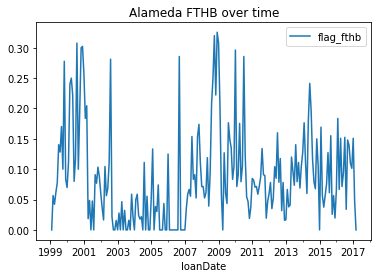

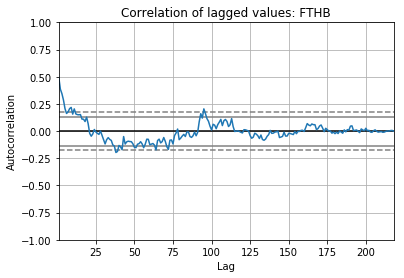

In [23]:
df_test_pred2.plot()
pyplot.title('Alameda FTHB over time')
pyplot.savefig('visualizations/fthb_over_time_alameda.png')
pyplot.show()
autocorrelation_plot(df_test_pred2)
pyplot.title('Correlation of lagged values: FTHB')
pyplot.savefig('visualizations/timecorrelation_fthb_alameda.png')
pyplot.show()

                             ARIMA Model Results                              
Dep. Variable:            D.flag_fthb   No. Observations:                  217
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 281.509
Method:                       css-mle   S.D. of innovations              0.066
Date:                Wed, 14 Nov 2018   AIC                           -551.018
Time:                        21:07:32   BIC                           -530.739
Sample:                    03-01-1999   HQIC                          -542.826
                         - 03-01-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -8.228e-06      0.001     -0.009      0.993      -0.002       0.002
ar.L1.D.flag_fthb    -0.7087      0.099     -7.184      0.000      -0.902      -0.515
ar.L2.D.flag_fthb     0.

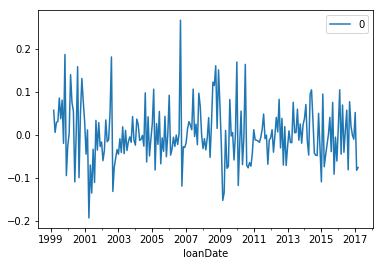

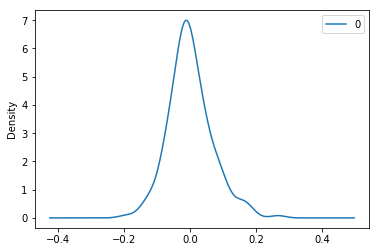

                0
count  217.000000
mean     0.001131
std      0.066245
min     -0.193718
25%     -0.038676
50%     -0.006000
75%      0.036188
max      0.266057


In [26]:
# fit model
model = ARIMA(df_test_pred2, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.savefig('visualizations/residuals_fthb_alameda.png')
pyplot.show()
residuals.plot(kind='kde')
pyplot.savefig('visualizations/residuals_fthb_kdensity_alameda.png')
pyplot.show()
print(residuals.describe())

In [25]:
from sklearn.metrics import mean_squared_error
import warnings
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [1, 2, 3]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_test_pred2.values, p_values, d_values, q_values)


ARIMA(1, 0, 0) MSE=0.003
ARIMA(1, 0, 1) MSE=0.002
ARIMA(1, 1, 0) MSE=0.003
ARIMA(1, 1, 1) MSE=0.003
ARIMA(1, 1, 2) MSE=0.003
ARIMA(1, 2, 0) MSE=0.006
ARIMA(2, 0, 0) MSE=0.003
ARIMA(2, 0, 1) MSE=0.003
ARIMA(2, 0, 2) MSE=0.002
ARIMA(2, 1, 0) MSE=0.003
ARIMA(2, 1, 1) MSE=0.003
ARIMA(2, 1, 2) MSE=0.003
ARIMA(2, 2, 0) MSE=0.005
ARIMA(3, 0, 0) MSE=0.003
ARIMA(3, 0, 2) MSE=0.002
ARIMA(3, 1, 0) MSE=0.003
ARIMA(3, 2, 0) MSE=0.005
Best ARIMA(2, 0, 2) MSE=0.002


In [28]:
X = df_test_pred2.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


predicted=0.036361, expected=0.084746
predicted=0.058548, expected=0.081967
predicted=0.071760, expected=0.070423
predicted=0.077125, expected=0.071429
predicted=0.074556, expected=0.058824
predicted=0.064890, expected=0.071429
predicted=0.069402, expected=0.086957
predicted=0.077184, expected=0.134146
predicted=0.109445, expected=0.090909
predicted=0.099630, expected=0.089552
predicted=0.102209, expected=0.019231
predicted=0.052239, expected=0.046875
predicted=0.052316, expected=0.059701
predicted=0.047085, expected=0.078125
predicted=0.066938, expected=0.035088
predicted=0.050506, expected=0.051948
predicted=0.055467, expected=0.104167
predicted=0.076471, expected=0.085106
predicted=0.081180, expected=0.160000
predicted=0.131590, expected=0.078431
predicted=0.098153, expected=0.117647
predicted=0.120934, expected=0.031746
predicted=0.062526, expected=0.078125
predicted=0.078049, expected=0.015873
predicted=0.033971, expected=0.016667
predicted=0.031321, expected=0.066667
predicted=0.

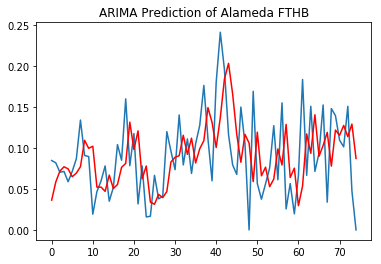

In [30]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.title('ARIMA Prediction of Alameda FTHB')

pyplot.savefig('visualizations/arimapreds_fthb_alameda.png')
pyplot.show()

In [78]:
model_fit.forecast(steps=6)[0]

array([710.78009934, 708.48074436, 707.55485539, 706.65847819,
       705.76273511, 704.86700567])

In [46]:
#taking the average of the next 6-months' of predictions
model_fit.forecast(steps=6)[0].mean()

0.08721914245170868

In [32]:
df_test_time = df_pred
# df_test_time = df_test_pred.index.to_julian_date()
df_test_time['Date'] = df_pred['loanDate'].map(pd.datetime.toordinal)
df_test_time = df_test_time[df_test_time['zipcode'] == '945']
df_test_time = df_test_time.drop(columns=['loanDate', 'zipcode','fico'])
df_test_time.sort_values(by=['Date'])
df_test_time.head(5)

,flag_fthb,Date
137861,0.000000,729786
137862,0.056604,729814
137863,0.042254,729845
137864,0.061538,729875
137865,0.077922,729906


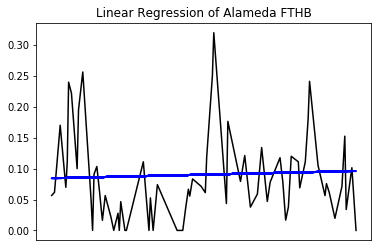

In [34]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df_test_time['Date'], df_test_time['flag_fthb'], test_size=0.33)


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(np.array(X_train).reshape(-1, 1), y_train)

# Make predictions using the testing set
y_pred = regr.predict(np.array(X_test).reshape(-1, 1))

# Plot outputs
xs, ys = zip(*sorted(zip(X_test, y_test)))
pyplot.plot(xs, ys,  color='black')
pyplot.plot(X_test, y_pred, color='blue', linewidth=2)

pyplot.xticks(())
# pyplot.yticks(())
pyplot.title('Linear Regression of Alameda FTHB')

pyplot.savefig('visualizations/linearpred_fthb_alameda.png')
pyplot.show()


## Merging with Cross-Walk

In [175]:
#Working with the crosswalk set
walkies = pd.read_csv('data/zip_county_crosswalk.csv', sep=',')
print(walkies.head(5))
walkies = walkies[walkies.columns[0:4]]
walkies['zipcode'] = [str(x)[:-2] for x in walkies['ZIP']]
walkies['county'] = [' '.join(x.split(' ')[:-1]) for x in walkies['COUNTYNAME']]
walkies = walkies[walkies.columns[2:]]
#walkies = walkies.loc[walkies['STATE'] == 'TX']
walkies = walkies.drop_duplicates()

     ZIP      COUNTYNAME STATE  STCOUNTYFP CLASSFP
0  36003  Autauga County    AL        1001      H1
1  36006  Autauga County    AL        1001      H1
2  36067  Autauga County    AL        1001      H1
3  36066  Autauga County    AL        1001      H1
4  36703  Autauga County    AL        1001      H1


In [176]:
walkies.head(5)

,STATE,STCOUNTYFP,zipcode,county
0,AL,1001,360,Autauga
4,AL,1001,367,Autauga
13,AL,1003,365,Baldwin
38,AL,1003,364,Baldwin
41,AL,1005,360,Barbour


In [177]:
#merging that combined list with freddiemac
df_merged = pd.merge(df_FM, walkies, how='left', on=['zipcode'])

/opt/conda/envs/data3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'zipcode' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [178]:
df_merged.head(5)

,fico,flag_fthb,zipcode,STATE,STCOUNTYFP,county
0,740,11.94,010,NaN,NaN,NaN
1,724,14.29,011,NaN,NaN,NaN
2,749,6.90,012,NaN,NaN,NaN
3,740,13.57,013,NaN,NaN,NaN
4,733,12.25,014,NaN,NaN,NaN


In [142]:
#reducing values in counties
df_All = df_merged.groupby(['county','STATE'])['fico', 'flag_fthb'].mean()
#moving county names to column
df_All = df_All.reset_index()

## From DF to List - List needed to graph on Bokeh

In [143]:
df_All.head(5)

,county,STATE,fico,flag_fthb
0,Abbeville,SC,733.50,10.0200
1,Acadia,LA,728.00,10.5700
2,Accomack,VA,736.00,6.8700
3,Ada,ID,738.50,8.1500
4,Adair,IA,738.75,13.1875


In [144]:
list_All = [list(x) for x in df_All.values]

In [145]:
list_All[1]

['Acadia', 'LA', 728.0, 10.57]

In [147]:
list_All = [[x[0],x[1],x[2],x[3]] for x in list_All if x]
list_All = sorted(list_All)
list_All[:5]

[['Abbeville', 'SC', 733.5, 10.02],
 ['Acadia', 'LA', 728.0, 10.57],
 ['Accomack', 'VA', 736.0, 6.87],
 ['Ada', 'ID', 738.5, 8.15],
 ['Adair', 'IA', 738.75, 13.1875]]

In [148]:
list_All[:5]

[['Abbeville', 'SC', 733.5, 10.02],
 ['Acadia', 'LA', 728.0, 10.57],
 ['Accomack', 'VA', 736.0, 6.87],
 ['Ada', 'ID', 738.5, 8.15],
 ['Adair', 'IA', 738.75, 13.1875]]

In [149]:
county_fthb = [round(x[3],2) for x in list_All]
county_fico = [int(float(x[2])) for x in list_All]

In [150]:
county_fico[:5]

[733, 728, 736, 738, 738]

In [151]:
county_fthb[:5]

[10.02, 10.57, 6.87, 8.15, 13.19]

In [ ]:
objects_list = ['county_names','county_xs','county_ys','county_fico','county_fthb']


In [220]:
#Takes in df_All, and outputs the necessary files to graph everything

graph_data = dict()

for stAbbrv in state_list:
    temp_df = df_All[df_All['STATE'] == stAbbrv]
    print(stAbbrv)
    list_All = [list(x) for x in temp_df.values]
    list_All = [[x[0],x[1],x[2],x[3]] for x in list_All if x]
    list_All = sorted(list_All)
    county_fthb = [round(x[3],2) for x in list_All]
    county_fico = [int(float(x[2])) for x in list_All]
    
    statelower = stAbbrv.lower()
    counties = _read_data()
    counties = {
        code: county for code, county in counties.items() if county['state'] == statelower} 

    county_xs = [county["lons"] for county in counties.values()]
    county_ys = [county["lats"] for county in counties.values()]
    county_names = [county['name'] for county in counties.values()]
    county_states = [county['state'] for county in counties.values()]
    
    full_path = 'data/mortgage/' + stAbbrv + '/' + stAbbrv + '_full.p'
    full_list = [county_names, county_xs, county_ys, county_fico, county_fthb]
    graph_data[stAbbrv] = full_list
    with open(full_path, 'wb') as fp:
        pickle.dump(full_list, fp)

AK
AL
AR
AZ
CA
CO
CT
DE
FL
GA
HI
IA
ID
IL
IN
KS
KY
LA
MA
MD
ME
MI
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
NY
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VA
VT
WA
WI
WV
WY


In [221]:
#saving graph_data
with open('data/graph_data.p', 'wb') as fp:
    pickle.dump(graph_data, fp)

## Extra Code and/or Future Work

In [ ]:
#Creating the scalar process
def scale_var(variable):
    v_mean = variable.mean()
    v_sd = variable.sd()
    v_scaled = []
    for each var in variable:
        v_diff = variable - v_mean
        v_scaled.append(v_diff/v_sd)
    return v_scaled
Subtract the mean, μ, from the value you want to convert, X.
Divide the result from Step 1 by the standard deviation, σ.

In [ ]:
your relationship to avg credit score
You are -50 from the average credit score

user_diff_by_county = input_credit - county_avg

"Your credit score is % from the average in this county."

In [ ]:
Turn FTHB% into a relativized score across the state. 
FTHB_range = range(fthb) across all counties in the state
FTHB_scalar = scale fthb over the range of fthb

FTHB_county_rank = 

In [ ]:
Years it would take you to buy the average home in each county 
avgHP by county
user_years_by_county = avgHPCounty/input_income

"It would take you % years to buy the average home in this county."

avgHP_range = range(avgHP) across all counties in the state
avgHP_scalar = scale avgHP over the range of avgHP

In [ ]:
Conversely, you could take the avg house price, calculate the number of years to buy that house, and use that as a scalar. 
1 - the most expensive house, you would take the most years to pay this off
-1 - the least expensive house, you would take the least time to pay off this house
tooltip could say how long it would take you to get that house

In [ ]:
combine the three scores
FICO_scalar+FTHB_scalar+AvgHP_scalar

In [59]:
# df_graph_fico = df.drop(columns=['Unnamed: 0','Unnamed: 0.1','flag_fthb','zipcode','st'])
# df_graph_fico.to_csv('data/mortgage/fico_graph.csv')
# print(df_graph_fico.head(5))
# df_graph_fthb = df.drop(columns=['Unnamed: 0','Unnamed: 0.1','fico','zipcode','st'])
# df_graph_fthb.to_csv('data/mortgage/fthb_graph.csv')
# print(df_graph_fthb.head(5))

In [60]:
# df_graph_fico['avgFico'] = df_graph_fico.groupby(['loanDate'])['fico'].transform('mean')

# df_graph_fico.head(5)

In [61]:
# ####%FTHB
# #first need to calculate out the count of all home loans by category
# df_graph_fthb['loan_n'] = df_graph_fthb.groupby(['loanDate', 'st'])['flag_fthb'].transform('count')
# #then need to do a ratio of FTHB over all loans by category
# df_graph_fthb['FTHB'] = df_graph_fthb['flag_fthb'].astype(int)
# #creating the number of first time home buyers by state
# df_graph_fthb['loan_fthb_n'] = df_graph_fthb.groupby(['loanDate'])['flag_fthb'].transform('sum')
# #creating the percentage of fthb over all loans, multiplying by 100 to be more intuitive
# df_graph_fthb['fthb_perc'] = df_graph_fthb['loan_fthb_n'] / df_graph_fthb['loan_n'] * 100

# df_graph_fthb.head(5)

In [ ]:
# from scipy.stats import sem  
  
# # This function takes an array of numbers and smoothes them out.  
# # Smoothing is useful for making plots a little easier to read.  
# def sliding_mean(data_array, window=5):  
#     data_array = array(df_graph_fico['fico'])  
#     new_list = []  
#     for i in range(len(data_array)):  
#         indices = range(max(i - window + 1, 0),  
#                         min(i + window + 1, len(data_array)))  
#         avg = 0  
#         for j in indices:  
#             avg += data_array[j]  
#         avg /= float(len(indices))  
#         new_list.append(avg)  
          
#     return array(new_list) 

# years = df.groupby("dt_first_pi").PlyCount.mean().keys()  
# mean_PlyCount = sliding_mean(df.groupby("dt_first_pi").PlyCount.mean().values,  
#                              window=10)  
# sem_PlyCount = sliding_mean(df.groupby("dt_first_pi").PlyCount.apply(sem).mul(1.96).values,  
#                             window=10)  

In [62]:
# #see the general shape of the data
# df_graph_fico.plot()
# pyplot.show()


In [63]:
# #see the general shape of the data
# df_graph_fthb.plot()
# pyplot.show()

In [64]:
# pyplot.plot( 'loanDate', 'avgFico', data=df_graph_fico, color='skyblue', linewidth=4)
# pyplot.legend()
# pyplot.show()
